In [3]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
df = pd.read_csv("dive_site_dataset.csv") #Read data from file
print(df.head(6))


             timestamp   latitude  longitude  depth_m  temp_c    pH  salinity  \
0  2024-01-25 20:31:30  31.304047  29.891138    11.35   17.65  8.05     36.35   
1  2024-01-17 04:36:55  31.311244  29.901592    26.53   17.64  8.16     36.70   
2  2024-01-05 23:59:32  31.311104  29.907095    31.85   18.97  8.14     36.39   
3  2024-01-24 18:33:59  31.313362  29.903485    31.77   15.90  8.13     36.01   
4  2024-01-14 14:58:23  31.308046  29.891870    16.10   18.85  8.21     36.51   
5  2024-01-18 05:16:54  31.304098  29.892412    35.57   17.04  8.07     37.81   

   dissolved_oxygen  co2_ppm  light_intensity  turbidity  change_factor  \
0              5.74    444.2            146.5       4.27           7.66   
1              5.92    483.1             83.8       6.14           0.30   
2              4.20    468.8             50.0       7.10           3.07   
3              5.07    472.3             50.0       8.27           3.95   
4              6.40    475.7             50.0       2.96 

In [106]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         150000 non-null  object 
 1   latitude          150000 non-null  float64
 2   longitude         150000 non-null  float64
 3   depth_m           150000 non-null  float64
 4   temp_c            150000 non-null  float64
 5   pH                150000 non-null  float64
 6   salinity          150000 non-null  float64
 7   dissolved_oxygen  150000 non-null  float64
 8   co2_ppm           150000 non-null  float64
 9   light_intensity   150000 non-null  float64
 10  turbidity         150000 non-null  float64
 11  change_factor     150000 non-null  float64
 12  site_status       150000 non-null  object 
dtypes: float64(11), object(2)
memory usage: 14.9+ MB
None


In [107]:
print(df.isnull().sum())

timestamp           0
latitude            0
longitude           0
depth_m             0
temp_c              0
pH                  0
salinity            0
dissolved_oxygen    0
co2_ppm             0
light_intensity     0
turbidity           0
change_factor       0
site_status         0
dtype: int64


In [108]:
print("Number of duplicated rows:", df.duplicated().sum())
duplicates = df[df.duplicated()]
print(duplicates)


Number of duplicated rows: 0
Empty DataFrame
Columns: [timestamp, latitude, longitude, depth_m, temp_c, pH, salinity, dissolved_oxygen, co2_ppm, light_intensity, turbidity, change_factor, site_status]
Index: []


In [14]:
# تحويل timestamp إلى datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# ميزات زمنية مباشرة ومفهومة
df["hour"] = df["timestamp"].dt.hour
df["day"] = df["timestamp"].dt.day
df["month"] = df["timestamp"].dt.month
df["weekday"] = df["timestamp"].dt.weekday
df["day_of_year"] = df["timestamp"].dt.dayofyear

# دلوقتي فقط نشيل العمود الأصلي
df = df.drop(columns=["timestamp"])


In [110]:
df.head()

,latitude,longitude,depth_m,temp_c,pH,salinity,dissolved_oxygen,co2_ppm,light_intensity,turbidity,change_factor,site_status,hour,day,month,weekday,day_of_year
0,31.304047,29.891138,11.35,17.65,8.05,36.35,5.74,444.2,146.5,4.27,7.66,Stable,20,25,1,3,25
1,31.311244,29.901592,26.53,17.64,8.16,36.70,5.92,483.1,83.8,6.14,0.30,Stable,4,17,1,2,17
2,31.311104,29.907095,31.85,18.97,8.14,36.39,4.20,468.8,50.0,7.10,3.07,Unstable,23,5,1,4,5
3,31.313362,29.903485,31.77,15.90,8.13,36.01,5.07,472.3,50.0,8.27,3.95,Dangerous,18,24,1,2,24
4,31.308046,29.891870,16.10,18.85,8.21,36.51,6.40,475.7,50.0,2.96,4.36,Unstable,14,14,1,6,14


In [111]:
df = df.drop(columns=["day_of_year", "weekday"])
df.nunique().sort_values()


site_status             3
month                  12
hour                   24
day                    31
pH                     52
salinity              201
dissolved_oxygen      349
change_factor         688
co2_ppm              1001
turbidity            1145
temp_c               1450
depth_m              3801
light_intensity      7793
longitude           19988
latitude            19992
dtype: int64

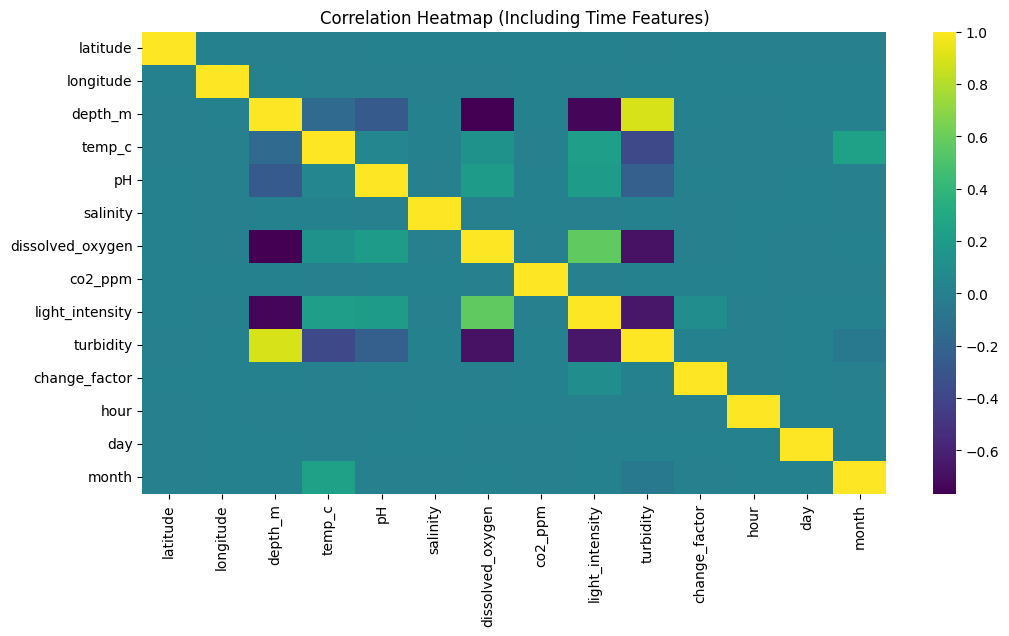

In [112]:
# دلوقتي نقدر نعمل correlation شامل
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12,6))
sns.heatmap(numeric_df.corr(), annot=False, cmap="viridis")
plt.title("Correlation Heatmap (Including Time Features)")
plt.show()

In [ ]:
columns_to_drop = ["latitude", "longitude", "timestamp", "day_of_year", "weekday","day","hour"]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

In [114]:
df.head()

,depth_m,temp_c,pH,salinity,dissolved_oxygen,co2_ppm,light_intensity,turbidity,change_factor,site_status,month
0,11.35,17.65,8.05,36.35,5.74,444.2,146.5,4.27,7.66,Stable,1
1,26.53,17.64,8.16,36.70,5.92,483.1,83.8,6.14,0.30,Stable,1
2,31.85,18.97,8.14,36.39,4.20,468.8,50.0,7.10,3.07,Unstable,1
3,31.77,15.90,8.13,36.01,5.07,472.3,50.0,8.27,3.95,Dangerous,1
4,16.10,18.85,8.21,36.51,6.40,475.7,50.0,2.96,4.36,Unstable,1


In [16]:
encoder = LabelEncoder()
df['site_status'] = encoder.fit_transform(df['site_status'])
print(df['site_status'].value_counts())

site_status
1    111642
2     31369
0      6989
Name: count, dtype: int64


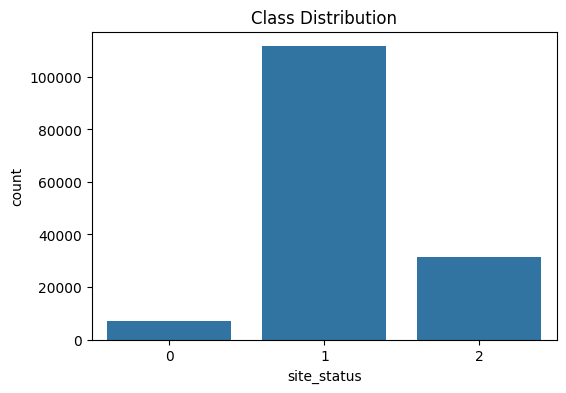

In [116]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['site_status'])
plt.title("Class Distribution")
plt.show()

In [17]:
X = df.drop(["site_status"], axis=1)
y = df['site_status']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=42, stratify=y)

In [24]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

numeric_cols = [col for col in numeric_cols if col in X_train.columns]


In [27]:
print(X_train2.shape)
print(y_train2.shape)


(210000, 10)
(210000,)


In [26]:
X_train2 = pd.concat([X_train, X_aug], axis=0).reset_index(drop=True)
y_train2 = pd.concat([y_train, y_train], axis=0).reset_index(drop=True)

In [121]:
scaler = StandardScaler()
X_train2[numeric_cols] = scaler.fit_transform(X_train2[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [123]:
print(X.columns.unique)


<bound method Index.unique of Index(['depth_m', 'temp_c', 'pH', 'salinity', 'dissolved_oxygen', 'co2_ppm',
       'light_intensity', 'turbidity', 'change_factor', 'month'],
      dtype='object')>


In [28]:
X_train2, y_train2 = shuffle(X_train2, y_train2, random_state=42)

In [29]:
X_aug_numeric = X_train[numeric_cols] + np.random.normal(0, 0.05, X_train[numeric_cols].shape)


In [30]:
X_aug = X_train.copy()
X_aug[numeric_cols] = X_aug_numeric



In [31]:
X.nunique()


depth_m             3801
temp_c              1450
pH                    52
salinity             201
dissolved_oxygen     349
co2_ppm             1001
light_intensity     7793
turbidity           1145
change_factor        688
month                 12
dtype: int64

In [ ]:
param_lr = {
    "penalty": ["l2", None],
    "C": [0.1, 1, 5, 10],
    "solver": ["lbfgs"],
    "max_iter": [300, 500]
}

grid_lr = GridSearchCV(
    LogisticRegression(),
    param_lr,
    cv=5,
    n_jobs=-1,
    scoring="accuracy"
)

grid_lr.fit(X_train2, y_train2)

print("Best LR Params:", grid_lr.best_params_)
print("Best LR Score:", grid_lr.best_score_)


Best LR Params: {'C': 0.1, 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}
Best LR Score: 0.9463952380952382


In [129]:
param_rf = {
    "n_estimators": [100, 200, 350],
    "max_depth": [4, 6, 8, None],
    "min_samples_split": [5, 10, 20],
    "min_samples_leaf": [4, 6, 10],
    "max_features": [0.3, 0.5, "sqrt"],
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_rf,
    cv=4,
    n_jobs=-1,
    scoring="accuracy"
)

grid_rf.fit(X_train2, y_train2)

print("Best RF Params:", grid_rf.best_params_)
print("Best RF Score:", grid_rf.best_score_)


Best RF Params: {'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 100}
Best RF Score: 0.9927285714285714


In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [38]:
models = {

    "LogisticRegression": LogisticRegression(
        C=0.01,
        max_iter=1000,
        penalty="l2",
        solver="lbfgs"
    ),

    "RandomForest_Improved": RandomForestClassifier(
    n_estimators=30,
    max_depth=4,
    min_samples_split=60,
    min_samples_leaf=15,
    max_features=0.25,
    random_state=42
)

}


In [39]:
results = {}
all_predictions = {}

for name, model in models.items():

    # Train
    model.fit(X_train2, y_train2)

    # Predict
    train_pred = model.predict(X_train2)
    test_pred = model.predict(X_test)

    # Accuracy
    train_acc = accuracy_score(y_train2, train_pred)
    test_acc = accuracy_score(y_test, test_pred)

    results[name] = test_acc
    all_predictions[name] = test_pred

    print(f"🔹 {name}")
    print(f"   Train Accuracy = {train_acc:.4f}")
    print(f"   Test Accuracy  = {test_acc:.4f}")
    print("--------------------------------------------------")

c:\Users\muhan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🔹 LogisticRegression
   Train Accuracy = 0.9422
   Test Accuracy  = 0.9401
--------------------------------------------------
🔹 RandomForest_Improved
   Train Accuracy = 0.9726
   Test Accuracy  = 0.9732
--------------------------------------------------


In [132]:
from sklearn.model_selection import cross_val_score

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train2, y_train2, cv=5)
    print(f"{name} CV Avg = {cv_scores.mean():.4f}")


LogisticRegression CV Avg = 0.9463
RandomForest_Improved CV Avg = 0.9927


In [133]:
from sklearn.metrics import classification_report

print(classification_report(y_test, test_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2097
           1       1.00      1.00      1.00     33492
           2       1.00      1.00      1.00      9411

    accuracy                           1.00     45000
   macro avg       1.00      1.00      1.00     45000
weighted avg       1.00      1.00      1.00     45000



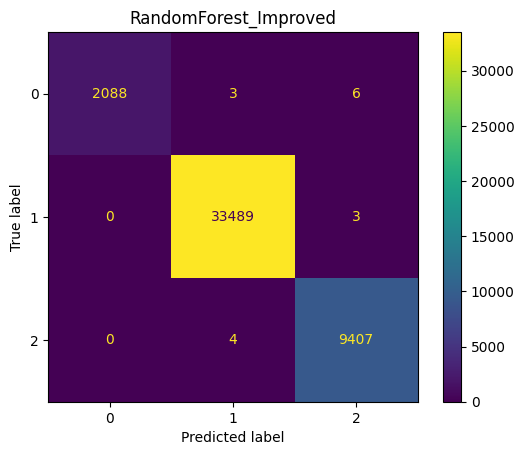

In [134]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred)
plt.title(name)
plt.show()


In [ ]:
# ----------------------------------
# Neural Network Model (PyTorch)
# ----------------------------------

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ----------------------------------
# Convert Data
# ----------------------------------
X_train_t = torch.tensor(X_train2.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train2.values, dtype=torch.long)
X_test_t  = torch.tensor(X_test.values,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values,  dtype=torch.long)

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=32,
    shuffle=True
)

# ----------------------------------
# Define Network
# ----------------------------------
class Net(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

num_classes = len(np.unique(y))
net = Net(X_train2.shape[1], num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    net.parameters(),
    lr=0.001,
    weight_decay=1e-4
)

# ----------------------------------
# Training Settings
# ----------------------------------
epochs = 100
patience = 6
best_loss = float("inf")
trigger = 0

train_losses = []
test_losses = []
train_accs = []
test_accs = []

# ----------------------------------
# Training Loop
# ----------------------------------
for epoch in range(epochs):

    net.train()
    batch_losses = []
    preds_list = []
    labels_list = []

    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = net(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        preds_list.append(out.argmax(dim=1))
        labels_list.append(yb)

    # Train metrics
    train_loss = sum(batch_losses) / len(batch_losses)
    train_preds = torch.cat(preds_list)
    train_labels = torch.cat(labels_list)
    train_acc = accuracy_score(train_labels.numpy(), train_preds.numpy())

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Test metrics
    net.eval()
    with torch.no_grad():
        test_out = net(X_test_t)
        test_loss = criterion(test_out, y_test_t).item()
        test_preds = test_out.argmax(dim=1)
        test_acc = accuracy_score(y_test_t.numpy(), test_preds.numpy())

    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1:03d} | "
          f"Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f} | "
          f"Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

    # Early stopping
    if test_loss < best_loss:
        best_loss = test_loss
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print(f"\n🔥 Early Stopping at epoch {epoch+1}")
            break

# ----------------------------------
# Final Evaluation
# ----------------------------------
net.eval()
with torch.no_grad():
    final_preds = net(X_test_t).argmax(dim=1)

nn_acc = accuracy_score(y_test, final_preds)
results["NeuralNetwork"] = nn_acc

print(f"\n🔹 Final Neural Network Test Accuracy = {nn_acc:.4f}")


Epoch 001 | Train Loss = 0.2857, Test Loss = 0.2910 | Train Acc = 0.8824, Test Acc = 0.8745
Epoch 002 | Train Loss = 0.2152, Test Loss = 0.1696 | Train Acc = 0.9149, Test Acc = 0.9303
Epoch 003 | Train Loss = 0.2102, Test Loss = 0.1922 | Train Acc = 0.9180, Test Acc = 0.9482
Epoch 004 | Train Loss = 0.2056, Test Loss = 0.1316 | Train Acc = 0.9208, Test Acc = 0.9604
Epoch 005 | Train Loss = 0.2022, Test Loss = 0.1916 | Train Acc = 0.9219, Test Acc = 0.9110
Epoch 006 | Train Loss = 0.1970, Test Loss = 0.1494 | Train Acc = 0.9232, Test Acc = 0.9319
Epoch 007 | Train Loss = 0.1923, Test Loss = 0.1456 | Train Acc = 0.9254, Test Acc = 0.9534
Epoch 008 | Train Loss = 0.1925, Test Loss = 0.1532 | Train Acc = 0.9256, Test Acc = 0.9363
Epoch 009 | Train Loss = 0.1893, Test Loss = 0.2458 | Train Acc = 0.9272, Test Acc = 0.8932
Epoch 010 | Train Loss = 0.1863, Test Loss = 0.1207 | Train Acc = 0.9280, Test Acc = 0.9571
Epoch 011 | Train Loss = 0.1864, Test Loss = 0.1158 | Train Acc = 0.9277, Test A

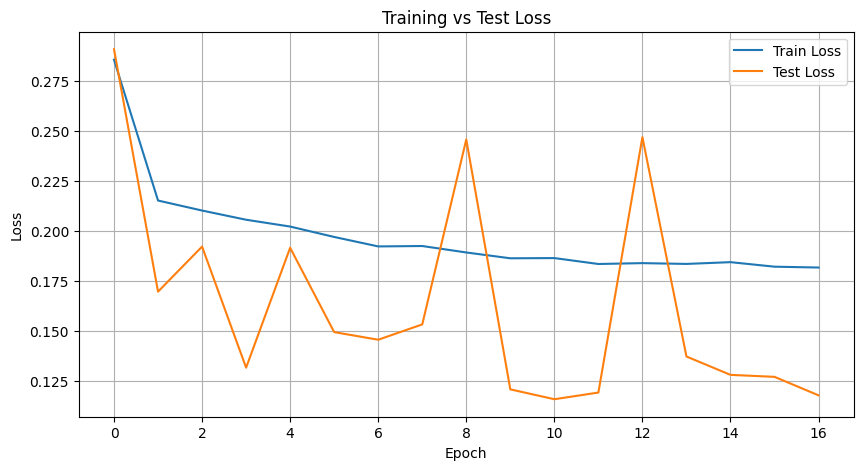

In [41]:
# Plot Loss curve
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()

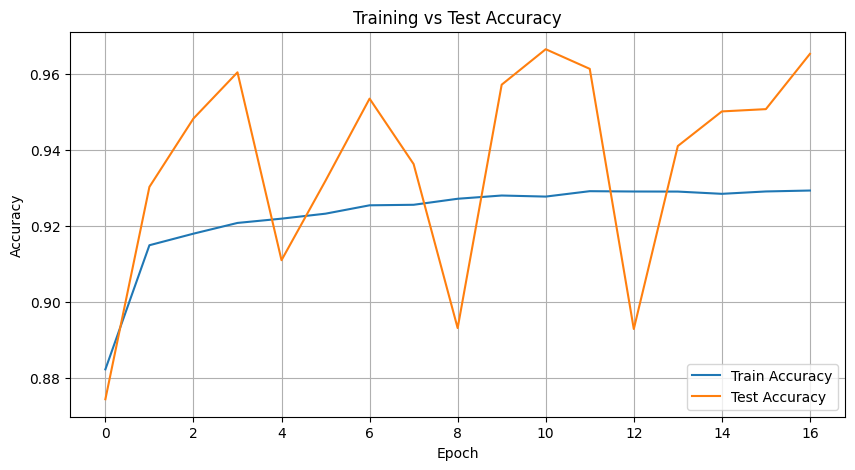

In [42]:
# Plot Accuracy curve
plt.figure(figsize=(10,5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

🔥 Best Model: RandomForest_Improved


<Figure size 600x500 with 0 Axes>

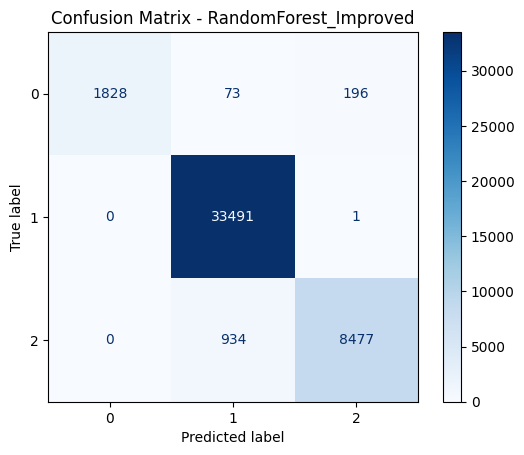

In [43]:
# ----------------------------------
# 12) Best Model + Confusion Matrix
# ----------------------------------

best_model_name = max(results, key=results.get)
print("🔥 Best Model:", best_model_name)

if best_model_name == "NeuralNetwork":
    cm = confusion_matrix(y_test, preds)
else:
    model = models[best_model_name]
    pred = model.predict(X_test)
    cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(6,5))
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()


            Feature  Importance
4  dissolved_oxygen    0.378526
7         turbidity    0.196800
0           depth_m    0.186779
6   light_intensity    0.157707
1            temp_c    0.044263
8     change_factor    0.027992
9             month    0.005996
2                pH    0.001806
3          salinity    0.000084
5           co2_ppm    0.000046


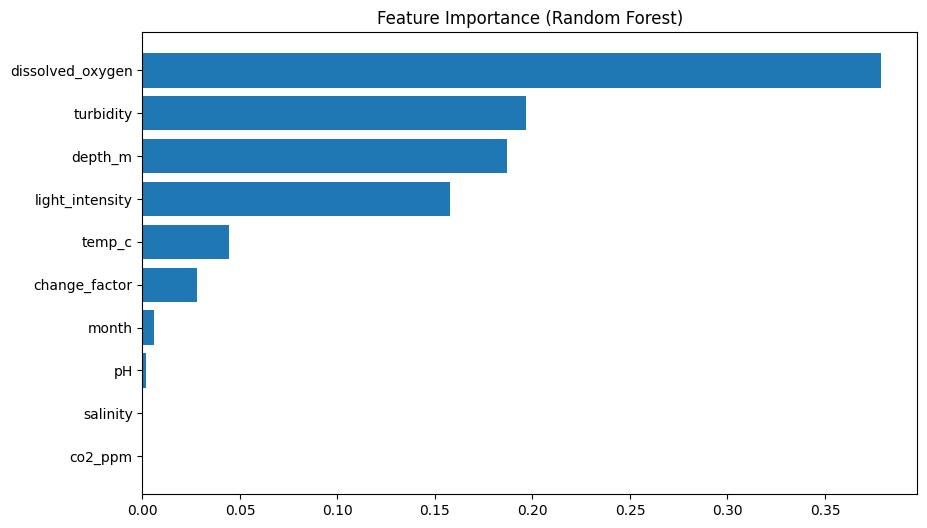

In [44]:
# ----------------------------------
# 13) Feature Importance (Random Forest)
# ----------------------------------
rf = models["RandomForest_Improved"]
importances = rf.feature_importances_
feature_names = X_train2.columns


feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances}) \
.sort_values(by="Importance", ascending=False)


print(feat_imp.head(20))


plt.figure(figsize=(10,6))
plt.barh(feat_imp["Feature"], feat_imp["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance (Random Forest)")
plt.show()

In [45]:
import torch

# مثال على TorchScript
example_input = torch.randn(1, X_train2.shape[1])  # 1 مثال، عدد Features
traced_net = torch.jit.trace(net, example_input)

# حفظ الموديل
traced_net.save("RandomForest_Improved.pt")
print("✅ TorchScript model saved as RandomForest_Improved.pt")


✅ TorchScript model saved as RandomForest_Improved.pt


In [46]:
import torch

# تأكد ان net في وضع evaluation
net.eval()

# مثال مدخل واحد
example_input = torch.randn(1, X_train2.shape[1])

# تصدير مباشر من PyTorch إلى ONNX
torch.onnx.export(
    net,                       # الموديل الأصلي
    example_input,             # مثال على البيانات
    "model.onnx",              # اسم الملف
    input_names=['input'], 
    output_names=['output'],
    opset_version=17,
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print("✅ Model exported to ONNX successfully")


✅ Model exported to ONNX successfully
